# **Deep Reinforcement Learning Class – Spring 2025 Assignment 2**

In this assignment, you will explore multiple exploration and exploitation methods, as well as variants of Monte Carlo Tree Search (MCTS), Temporal Difference (TD) learning, n-tuple approximation, and other key reinforcement learning techniques.

You will need to <font color='blue'>answer the bolded questions</font> and <font color='blue'>fill in the missing code snippets (marked by **TODO**)</font>.

Make a copy of this notebook using **File > Save a copy in Drive** and edit it with your answers.

**WARNING:** Do not include your name or any other personal identification information in this notebook.


### **Setup**

Run the following code to set up the necessary imports.


!pip install numpy==1.23.5
!pip install gym
!git clone https://github.com/JKCooper2/gym-bandits.git
!pip install /content/gym-bandits/.


In [1]:
import time
import gym
import gym_bandits
import numpy as np
import matplotlib.pyplot as plt

# Create Bandit environment
env = gym.make("BanditTenArmedGaussian-v0")

# **Question 1: Exploring and Enhancing MCTS with Exploration Strategies and TD Learning**

In this question, you will explore different **exploration strategies**, implement a **basic Monte Carlo Tree Search (MCTS)** with UCT, and enhance it using **Temporal Difference (TD) learning** with **n-tuple approximation** in the **2048 environment**.

You will start by comparing multiple **exploration-exploitation** techniques in a **multi-armed bandit** environment, then move on to **MCTS with UCT**, and finally integrate **TD-learning** to improve MCTS decision-making.

---

## **Steps:**

### **1. Compare Exploration Strategies in Multi-Armed Bandits**

- Implement and analyze **Exploration-First, Epsilon-Greedy, and UCB1** in a bandit setting.
- Compare how these methods balance **exploration and exploitation** and evaluate their performance over multiple runs.
- Discuss which method is most effective based on **average reward trends** and **long-term convergence behavior**.

### **2. Implement Basic MCTS with UCT for 2048**

- Develop a **Monte Carlo Tree Search (MCTS)** algorithm using **Upper Confidence Bound for Trees (UCT)**.
- Implement the **Selection, Expansion, Simulation, and Backpropagation** phases.
- Use **random rollouts** to estimate state values and guide decision-making.

### **3. Enhance MCTS with TD Learning and N-Tuple Approximation**

- Implement **Temporal Difference (TD) learning** with **n-tuple approximation** to estimate state values.
- Integrate this learned value function into **MCTS**, replacing the random rollout with a **TD-based evaluation**.
- Observe how the **learned value function improves MCTS efficiency and decision quality**.

By the end of this question, you will have built a **stronger MCTS agent** that intelligently balances exploration and exploitation and leverages **value function learning** to improve search accuracy.

🎯 How to Earn 15 Points?

1️⃣ Correct Implementation of Step 1 Agents (2 points)
/ Discussion of Three Methods (3 points)

2️⃣ Implementation of MCTS with UCT Formula and Rollout (4 points)
**Note: Points may be deducted for errors in formulas or function implementation.**

3️⃣ Correct Implementation of TD Learning + Explanation (4 points)

4️⃣ Integration of Value Approximator into MCTS + Explanation (2 points)


## Explore First Agent

In this cell we will dicuss an algorithm to solve bandits where,

- Exploration Phase: For the first N (defined as `max_explore` in the code) steps the agent takes random actions to estimate the value of different arms.
- Exploitation Phase: In each step after that, the agent identifies the best arm based on the information it aggregated so far.
  Notice that the agent keeps updating its prediction even after the inital N steps.

We will now implement this agent below.


In [2]:
import numpy as np


class ExplorationFirstAgent:
    def __init__(self, k=10, exploration_steps=100):
        """
        Initialize an Exploration-First Agent.

        Args:
        k (int): Number of possible actions.
        exploration_steps (int): Number of initial steps dedicated to pure exploration.

        Attributes:
        Q (np.array): Estimated value for each action.
        N (np.array): Count of times each action has been selected.
        t (int): Current time step.
        """
        self.k = k
        self.exploration_steps = exploration_steps
        self.Q = np.zeros(k)
        self.N = np.zeros(k)
        self.t = 0

    def select_action(self):
        # TODO: For the first N steps, perform exploration; afterward, exploit
        if self.t < self.exploration_steps:
            action = np.random.choice(self.k)
        else:
            action = np.argmax(self.Q)

        self.t += 1
        return action

    def update(self, action, reward):
        # TODO: Update N, Q, and t
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

## Epsilon-greedy Agent

A popular method of simultaneoulsy exploring/exploiting is $\epsilon$-greedy exploration. The main idea is to:

- Sample the (estimated) best action with probability $1-\epsilon$
- Perform a random action with probability $\epsilon$

By changing $\epsilon$, we can control if the agent is conservative or exploratory. We will now implement this agent.


In [3]:
import numpy as np


class EpsilonGreedyAgent:
    def __init__(self, k=10, epsilon=0.1):
        """
        Initialize an Epsilon-Greedy Agent.

        Args:
        epsilon (float): Probability of selecting a random action (exploration).
        """
        self.k = k
        self.epsilon = epsilon
        self.Q = np.zeros(k)
        self.N = np.zeros(k)

    def select_action(self):
        # TODO: With probability epsilon, select a random action (exploration); otherwise, select the action with the highest Q-value (exploitation)
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.k)
        else:
            action = np.argmax(self.Q)
        return action

    def update(self, action, reward):
        # TODO: Update N, Q
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

## UCB Agent

Unlike **Exploration-First**, which separates exploration and exploitation into distinct phases, or **Epsilon-Greedy**, which relies on random exploration, the **UCB (Upper Confidence Bound) agent** dynamically balances exploration and exploitation based on uncertainty.

The agent should be able to **intelligently decide when to explore and when to exploit**, rather than following a predefined exploration schedule or relying on random action selection.

Your task is to implement the `update_Q` and `get_action` methods for a UCB agent, ensuring that it effectively leverages its confidence bounds to make optimal decisions.

---

## UCB1 Formula

The UCB1 algorithm selects an action `a` based on the following equation:

$Q(a) + c \cdot \sqrt{\frac{\log t}{N(a)}}$

where:

- `Q(a)`: Estimated reward for action `a` (average of observed rewards).
- `N(a)`: Number of times action `a` has been selected.
- `t`: Total number of trials (time step).
- `c`: Exploration parameter (typically set to 1.0 or tuned based on problem complexity).

To implement this, you need to:

1. **Ensure that each action is selected at least once** before applying the UCB formula.
2. **Use the equation to compute UCB values** for all actions and select the one with the highest value.
3. **Update the estimated rewards `Q(a)` after each selection** using incremental averaging:

$Q(a) \gets Q(a) + \frac{(R - Q(a))}{N(a)}$

where `R` is the reward received from selecting action `a`.


In [4]:
import numpy as np


class UCB1Agent:
    def __init__(self, k=10, c=1.0):
        """
        Initialize a UCB1 Agent.

        Args:
        c (float): Exploration parameter that controls the balance between exploration and exploitation.
        """
        self.k = k
        self.c = c
        self.Q = np.zeros(k)
        self.N = np.zeros(k)
        self.t = 0

    def select_action(self):
        # TODO: Implement UCB1 action selection
        zero_indices = np.nonzero(self.N == 0)[0]
        if len(zero_indices) > 0:
            return np.random.choice(zero_indices)
        else:
            ucb_values = self.Q + self.c * np.sqrt(np.log(self.t) / self.N)
            return np.argmax(ucb_values)

    def update(self, action, reward):
        # TODO: Update N, Q, t
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]
        self.t += 1

## Simulation and Comparison of Exploration Strategies

This experiment compares the performance of three exploration strategies: **Exploration-First, Epsilon-Greedy, and UCB1**, in a **multi-armed bandit environment**. The simulation runs each strategy for **1000** steps across **50** independent runs to evaluate their average performance.

You should not modify this code—just run it to obtain the performance comparison between the three agents.


/tmp2/b10902118/micromamba/envs/2048/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/tmp2/b10902118/micromamba/envs/2048/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/tmp2/b10902118/micromamba/envs/2048/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'int'>`
  logger.warn(
/tmp2/b10902118/micromamba/envs/2048/lib/python3.8/site-packages/gym/utils/passive

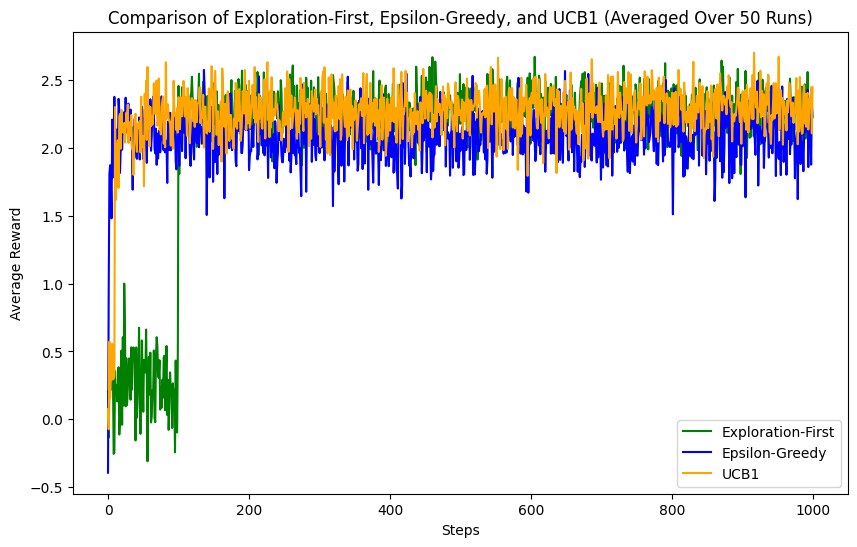

Final 200-step Avg Reward - Exploration-First: 2.281, Epsilon-Greedy: 2.108, UCB1: 2.303
✅ UCB1 performs the best in the long run!


In [5]:
def simulate(env, agent, steps=1000):
    rewards = np.zeros(steps)

    for t in range(steps):
        action = agent.select_action()
        observation, reward, done, info = env.step(action)
        agent.update(action, reward)
        rewards[t] = reward

    return rewards


num_runs = 50
steps = 1000

all_rewards_exp_first = []
all_rewards_eg = []
all_rewards_ucb = []

for _ in range(num_runs):
    env.reset()
    exp_first_agent = ExplorationFirstAgent(k=10, exploration_steps=100)
    rewards_exp_first = simulate(env, exp_first_agent, steps)
    all_rewards_exp_first.append(rewards_exp_first)

    env.reset()
    epsilon_greedy_agent = EpsilonGreedyAgent(k=10, epsilon=0.1)
    rewards_eg = simulate(env, epsilon_greedy_agent, steps)
    all_rewards_eg.append(rewards_eg)

    env.reset()
    ucb_agent = UCB1Agent(k=10, c=1.0)
    rewards_ucb = simulate(env, ucb_agent, steps)
    all_rewards_ucb.append(rewards_ucb)

avg_rewards_exp_first = np.mean(all_rewards_exp_first, axis=0)
avg_rewards_eg = np.mean(all_rewards_eg, axis=0)
avg_rewards_ucb = np.mean(all_rewards_ucb, axis=0)

plt.figure(figsize=(10, 6))

plt.plot(avg_rewards_exp_first, label="Exploration-First", color="green")
plt.plot(avg_rewards_eg, label="Epsilon-Greedy", color="blue")
plt.plot(avg_rewards_ucb, label="UCB1", color="orange")

plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title(
    "Comparison of Exploration-First, Epsilon-Greedy, and UCB1 (Averaged Over 50 Runs)"
)
plt.legend()
plt.show()


final_avg_exp_first = np.mean(avg_rewards_exp_first[-200:])
final_avg_eg = np.mean(avg_rewards_eg[-200:])
final_avg_ucb = np.mean(avg_rewards_ucb[-200:])

print(
    f"Final 200-step Avg Reward - Exploration-First: {final_avg_exp_first:.3f}, Epsilon-Greedy: {final_avg_eg:.3f}, UCB1: {final_avg_ucb:.3f}"
)

if final_avg_exp_first > final_avg_eg and final_avg_exp_first > final_avg_ucb:
    print("✅ Exploration-First performs the best in the long run!")
elif final_avg_eg > final_avg_exp_first and final_avg_eg > final_avg_ucb:
    print("✅ Epsilon-Greedy performs the best in the long run!")
else:
    print("✅ UCB1 performs the best in the long run!")

**Question (3pts):**

Based on the plotted results, which exploration strategy (**Exploration-First, Epsilon-Greedy, or UCB1**) performed the best? Why?

Analyze the reasons behind this outcome. How do different strategies balance exploration and exploitation, leading to these results?  
Provide an explanation based on the observed trends, identifying which strategy was the most effective in this environment and comparing its advantages and limitations to the others.

**Answer:**

- Exploration-First performs bad in the beginning due to pure random action. It focuses on current best actions in the late stage, but current best can be sub-optimal.

- Epsilon-Greedy's 0.1 probability for random act can be harmful in the late stage.

- UCB1 ensures all actions are well explored and the bound approaches pure Q-value (pure exploit).

UCB1 performs the best

Limitation: UCB1 must have all actions tried once. It will struggle with large action space.


## Applying Exploration Strategies to 2048: MCTS and TD-Learning

Now that you have explored different **exploration strategies** and gained an understanding of how they balance exploration and exploitation, it’s time to apply these concepts to a more complex decision-making problem: **the game of 2048**.

In this section, you will implement **Monte Carlo Tree Search (MCTS) with UCT** and enhance it using **Temporal Difference (TD) learning with n-tuple approximation**. Before diving into the implementation, take a moment to develop an intuition for the game itself. You can try playing 2048 at this [link](https://play2048.co/) to familiarize yourself with its mechanics.

You **do not** need to modify the provided 2048 environment code. However, if you find that certain adjustments could improve your training process, feel free to make changes. Just ensure that your modifications **do not alter the fundamental behavior of the environment**.

**_Note: While some versions of 2048 terminate as soon as the 2048 tile is reached, our environment will continue running until no legal moves remain._**

Now, let’s move forward with implementing **MCTS and TD-learning**, leveraging what we've learned about exploration and structured search to improve decision-making in 2048!


In [6]:
import numpy as np
import random
import gym
from gym import spaces
import matplotlib.pyplot as plt

COLOR_MAP = {
    0: "#cdc1b4",
    2: "#eee4da",
    4: "#ede0c8",
    8: "#f2b179",
    16: "#f59563",
    32: "#f67c5f",
    64: "#f65e3b",
    128: "#edcf72",
    256: "#edcc61",
    512: "#edc850",
    1024: "#edc53f",
    2048: "#edc22e",
    4096: "#3c3a32",
    8192: "#3c3a32",
    16384: "#3c3a32",
    32768: "#3c3a32",
}
TEXT_COLOR = {
    2: "#776e65",
    4: "#776e65",
    8: "#f9f6f2",
    16: "#f9f6f2",
    32: "#f9f6f2",
    64: "#f9f6f2",
    128: "#f9f6f2",
    256: "#f9f6f2",
    512: "#f9f6f2",
    1024: "#f9f6f2",
    2048: "#f9f6f2",
    4096: "#f9f6f2",
}


class Game2048Env(gym.Env):
    def __init__(self):
        super(Game2048Env, self).__init__()

        self.size = 4
        self.board = np.zeros((self.size, self.size), dtype=int)
        self.score = 0

        # Action space: 0: up, 1: down, 2: left, 3: right
        self.action_space = spaces.Discrete(4)
        self.actions = ["up", "down", "left", "right"]

        self.last_move_valid = True

        self.reset()

    def reset(self):
        self.board = np.zeros((self.size, self.size), dtype=int)
        self.score = 0
        self.add_random_tile()
        self.add_random_tile()
        return self.board

    def add_random_tile(self):
        empty_cells = list(zip(*np.where(self.board == 0)))
        if empty_cells:
            x, y = random.choice(empty_cells)
            self.board[x, y] = 2 if random.random() < 0.9 else 4

    def compress(self, row):
        new_row = row[row != 0]
        new_row = np.pad(new_row, (0, self.size - len(new_row)), mode="constant")
        return new_row

    def merge(self, row):
        for i in range(len(row) - 1):
            if row[i] == row[i + 1] and row[i] != 0:
                row[i] *= 2
                row[i + 1] = 0
                self.score += row[i]
        return row

    def move_left(self):
        moved = False
        for i in range(self.size):
            original_row = self.board[i].copy()
            new_row = self.compress(self.board[i])
            new_row = self.merge(new_row)
            new_row = self.compress(new_row)
            self.board[i] = new_row
            if not np.array_equal(original_row, self.board[i]):
                moved = True
        return moved

    def move_right(self):
        moved = False
        for i in range(self.size):
            original_row = self.board[i].copy()
            reversed_row = self.board[i][::-1]
            reversed_row = self.compress(reversed_row)
            reversed_row = self.merge(reversed_row)
            reversed_row = self.compress(reversed_row)
            self.board[i] = reversed_row[::-1]
            if not np.array_equal(original_row, self.board[i]):
                moved = True
        return moved

    def move_up(self):
        moved = False
        for j in range(self.size):
            original_col = self.board[:, j].copy()
            col = self.compress(self.board[:, j])
            col = self.merge(col)
            col = self.compress(col)
            self.board[:, j] = col
            if not np.array_equal(original_col, self.board[:, j]):
                moved = True
        return moved

    def move_down(self):
        moved = False
        for j in range(self.size):
            original_col = self.board[:, j].copy()
            reversed_col = self.board[:, j][::-1]
            reversed_col = self.compress(reversed_col)
            reversed_col = self.merge(reversed_col)
            reversed_col = self.compress(reversed_col)
            self.board[:, j] = reversed_col[::-1]
            if not np.array_equal(original_col, self.board[:, j]):
                moved = True
        return moved

    def is_game_over(self):
        if np.any(self.board == 0):
            return False
        for i in range(self.size):
            for j in range(self.size - 1):
                if self.board[i, j] == self.board[i, j + 1]:
                    return False
        for j in range(self.size):
            for i in range(self.size - 1):
                if self.board[i, j] == self.board[i + 1, j]:
                    return False

        return True

    def step(self, action):
        assert self.action_space.contains(action), "Invalid action"

        if action == 0:
            moved = self.move_up()
        elif action == 1:
            moved = self.move_down()
        elif action == 2:
            moved = self.move_left()
        elif action == 3:
            moved = self.move_right()
        else:
            moved = False

        self.last_move_valid = moved

        afterstate = self.board.copy()
        if moved:
            self.add_random_tile()

        done = self.is_game_over()

        return self.board.copy(), self.score, done, afterstate

    def render(self, mode="human", action=None):
        return
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(-0.5, self.size - 0.5)
        ax.set_ylim(-0.5, self.size - 0.5)

        for i in range(self.size):
            for j in range(self.size):
                value = self.board[i, j]
                color = COLOR_MAP.get(value, "#3c3a32")
                text_color = TEXT_COLOR.get(value, "white")
                rect = plt.Rectangle(
                    (j - 0.5, i - 0.5), 1, 1, facecolor=color, edgecolor="black"
                )
                ax.add_patch(rect)

                if value != 0:
                    ax.text(
                        j,
                        i,
                        str(value),
                        ha="center",
                        va="center",
                        fontsize=16,
                        fontweight="bold",
                        color=text_color,
                    )
        title = f"score: {self.score}"
        if action is not None:
            title += f" | action: {self.actions[action]}"
        plt.title(title)
        plt.gca().invert_yaxis()
        plt.show()

    def simulate_row_move(self, row):
        new_row = row[row != 0]
        new_row = np.pad(new_row, (0, self.size - len(new_row)), mode="constant")
        for i in range(len(new_row) - 1):
            if new_row[i] == new_row[i + 1] and new_row[i] != 0:
                new_row[i] *= 2
                new_row[i + 1] = 0
        new_row = new_row[new_row != 0]
        new_row = np.pad(new_row, (0, self.size - len(new_row)), mode="constant")
        return new_row

    def is_move_legal(self, action):
        temp_board = self.board.copy()

        if action == 0:  # Move up
            for j in range(self.size):
                col = temp_board[:, j]
                new_col = self.simulate_row_move(col)
                temp_board[:, j] = new_col
        elif action == 1:  # Move down
            for j in range(self.size):
                col = temp_board[:, j][::-1]
                new_col = self.simulate_row_move(col)
                temp_board[:, j] = new_col[::-1]
        elif action == 2:  # Move left
            for i in range(self.size):
                row = temp_board[i]
                temp_board[i] = self.simulate_row_move(row)
        elif action == 3:  # Move right
            for i in range(self.size):
                row = temp_board[i][::-1]
                new_row = self.simulate_row_move(row)
                temp_board[i] = new_row[::-1]
        else:
            raise ValueError("Invalid action")
        return not np.array_equal(self.board, temp_board)

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
from env import Game2048Env

This snippet initializes and runs a random agent in the 2048 environment, selecting moves randomly from the set of legal actions.

You can execute this code to observe the gameplay and get an estimate of the score when playing randomly. This will serve as a baseline to compare against more advanced techniques such as MCTS and TD-learning, helping you evaluate their effectiveness in improving performance.


In [8]:
env = Game2048Env()

scores = []
for _ in range(100):
    state = env.reset()
    # env.render()

    done = False
    while not done:
        legal_moves = [action for action in [0, 1, 2, 3] if env.is_move_legal(action)]
        action = random.choice(legal_moves)
        state, reward, done, _ = env.step(action)
    scores.append(env.score)
    # env.render(action=action)
print("Average score over 100 games:", np.mean(scores))

Average score over 100 games: 1064.28


## Introduction to MCTS with UCT and Rollout

In this section, we will implement Monte Carlo Tree Search (MCTS) using only the Upper Confidence Bound for Trees (UCT) formula and rollout, without any policy or value approximation.

MCTS consists of four main steps:

1. Selection – Traverse the tree by selecting child nodes based on the UCT formula, balancing exploration and exploitation.
2. Expansion – If a node has untried actions, expand the tree by adding a new child node.
3. Rollout (Simulation) – Perform a random simulation from the newly expanded node to estimate its value.
4. Backpropagation – Update the node's statistics by propagating the simulation result back up the tree.


In [9]:
import copy
import random
import math
import numpy as np


# UCT Node for MCTS
class UCTNode:
    def __init__(self, state, score, parent=None, action=None):
        """
        state: current board state (numpy array)
        score: cumulative score at this node (2048's?)
        parent: parent node (None for root)
        action: action taken from parent to reach this node
        """
        self.state = state
        self.score = score
        self.parent = parent
        self.action = action
        self.children = {}
        self.visits = 0
        self.total_reward = 0.0
        self.untried_actions = [
            a for a in range(4) if env.is_move_legal(a)
        ]  # already checked, including gameover

    def fully_expanded(self):
        # A node is fully expanded if no legal actions remain untried.
        return len(self.untried_actions) == 0


class UCTMCTS:
    def __init__(
        self, env, iterations=500, exploration_constant=1.41, rollout_depth=10
    ):
        self.env = env
        self.iterations = iterations
        self.c = exploration_constant  # Balances exploration and exploitation
        self.rollout_depth = rollout_depth

    def create_env_from_state(self, state, score):
        """
        Creates a deep copy of the environment with a given board state and score.
        """
        # new_env = Game2048Env()
        # new_env.reset(state, score)
        # return new_env
        new_env = copy.deepcopy(self.env)
        new_env.board = state.copy()
        new_env.score = score
        return new_env

    def select_child(self, node):
        # TODO: Use the UCT formula: Q + c * sqrt(log(parent_visits)/child_visits) to select the child
        if len(node.untried_actions) != 0:
            return node.children[node.untried_actions[0]]
        else:
            uct_max = -np.inf
            child_max = None
            for action, child in node.children.items():
                uct_value = child.total_reward / child.visits + self.c * np.sqrt(
                    np.log(node.visits) / child.visits
                )
                if uct_value > uct_max:
                    uct_max = uct_value
                    child_max = child

            return child_max

    def rollout(self, sim_env, depth):
        # TODO: Perform a random rollout from the current state up to the specified depth.
        score = sim_env.score
        while not sim_env.is_game_over() and depth > 0:
            legal_moves = [a for a in range(4) if sim_env.is_move_legal(a)]
            if len(legal_moves) == 0:
                break
            action = random.choice(legal_moves)
            state, score, done, _ = sim_env.step(action)
            depth -= 1

        return score

    def backpropagate(self, node, reward):
        # TODO: Propagate the reward up the tree, updating visit counts and total rewards.
        while node is not None:
            node.visits += 1
            node.total_reward += reward
            node = node.parent

    def run_simulation(self, root):
        node = root
        # results in avg 4337.2
        # sim_env = self.create_env_from_state(node.state, node.score)
        # TODO: Selection: Traverse the tree until reaching a non-fully expanded node.
        while node.fully_expanded():
            child = self.select_child(node)
            if child is None:
                break
            node = child

        # make env here should be correct
        sim_env = self.create_env_from_state(node.state, node.score)

        # TODO: Expansion: if the node has untried actions, expand one.
        if len(node.untried_actions) != 0:
            action = random.choice(node.untried_actions)
            node.untried_actions.remove(action)
            state, score, done, _ = sim_env.step(action)
            expanded_node = UCTNode(state, score)
            node.children[action] = expanded_node
            expanded_node.parent = node
            node = expanded_node

        # Rollout: Simulate a random game from the expanded node.
        rollout_reward = self.rollout(sim_env, self.rollout_depth)
        # Backpropagation: Update the tree with the rollout reward.
        self.backpropagate(node, rollout_reward)

    def best_action_distribution(self, root):
        """
        Computes the visit count distribution for each action at the root node.
        """
        total_visits = sum(child.visits for child in root.children.values())
        distribution = np.zeros(4)
        best_visits = -1
        best_action = None
        for action, child in root.children.items():
            distribution[action] = (
                child.visits / total_visits if total_visits > 0 else 0
            )
            if child.visits > best_visits:
                best_visits = child.visits
                best_action = action
        return best_action, distribution

### Playing 2048 Using MCTS

This section runs a 2048 game using Monte Carlo Tree Search (MCTS), selecting moves based on Upper Confidence Bound for Trees (UCT).


In [10]:
env = Game2048Env()
state = env.reset()
env.render()

# Instantiate the MCTS object with specified parameters
# You can adjust these parameters to experiment with different strategies
uct_mcts = UCTMCTS(env, iterations=50, exploration_constant=1.41, rollout_depth=10)

done = False
while not done:
    root = UCTNode(state, env.score)  # Initialize the root node for MCTS

    # Run multiple simulations to construct and refine the search tree
    for _ in range(uct_mcts.iterations):
        uct_mcts.run_simulation(root)

    # Select the best action based on the visit distribution of the root's children
    best_action, visit_distribution = uct_mcts.best_action_distribution(root)
    print(
        "MCTS selected action:",
        best_action,
        "with visit distribution:",
        visit_distribution,
    )

    state, reward, done, _ = env.step(best_action)
    env.render(action=best_action)  # Display the updated game state


print("Game over, final score:", env.score)

MCTS selected action: 1 with visit distribution: [0.02 0.92 0.02 0.04]
MCTS selected action: 1 with visit distribution: [0.02 0.88 0.02 0.08]
MCTS selected action: 3 with visit distribution: [0.02 0.   0.04 0.94]
MCTS selected action: 2 with visit distribution: [0.02 0.02 0.96 0.  ]
MCTS selected action: 1 with visit distribution: [0.02 0.94 0.02 0.02]
MCTS selected action: 0 with visit distribution: [0.96 0.   0.02 0.02]
MCTS selected action: 1 with visit distribution: [0.02 0.92 0.02 0.04]
MCTS selected action: 3 with visit distribution: [0.02 0.02 0.02 0.94]
MCTS selected action: 0 with visit distribution: [0.94 0.02 0.02 0.02]
MCTS selected action: 3 with visit distribution: [0.02 0.02 0.02 0.94]
MCTS selected action: 2 with visit distribution: [0.06 0.02 0.9  0.02]
MCTS selected action: 1 with visit distribution: [0.02 0.94 0.02 0.02]
MCTS selected action: 0 with visit distribution: [0.94 0.02 0.02 0.02]
MCTS selected action: 0 with visit distribution: [0.94 0.02 0.02 0.02]
MCTS s

"""
Average score over 10 games: 7317.2
Game over, final score: 7428
"""
```python
env = Game2048Env()
state = env.reset()
env.render()

# Instantiate the MCTS object with specified parameters
# You can adjust these parameters to experiment with different strategies
uct_mcts = UCTMCTS(env, iterations=50, exploration_constant=1.41, rollout_depth=10)


done = False
scores = []
for i in range(10):
    state = env.reset()
    done = False
    while not done:
        root = UCTNode(state, env.score)  # Initialize the root node for MCTS

        # Run multiple simulations to construct and refine the search tree
        for _ in range(uct_mcts.iterations):
            uct_mcts.run_simulation(root)

        # Select the best action based on the visit distribution of the root's children
        best_action, visit_distribution = uct_mcts.best_action_distribution(root)
        # print(
        #    "MCTS selected action:",
        #    best_action,
        #    "with visit distribution:",
        #    visit_distribution,
        # )

        state, reward, done, _ = env.step(best_action)
        env.render(action=best_action)  # Display the updated game state
    scores.append(env.score)

print("Average score over 10 games:", np.mean(scores))
print("Game over, final score:", env.score)
```

## **2048 TD Learning with N-Tuple Approximation**

### **What We Are Doing**

- We use **Temporal Difference (TD) learning** to train an **N-Tuple function approximator**.
- This approximator **estimates the value of a game state**, improving decision-making in 2048.
- Instead of storing every state, we utilize **small tile patterns (n-tuples)** to approximate the game board.
- Training involves **playing thousands of games** while updating weights based on rewards.

### **How It Works**

1. **Define N-Tuple Patterns**

   - These are small tile groups (e.g., rows, squares) used for function approximation.
   - **Rotations and flips** are applied to reduce redundancy and improve generalization.

2. **TD Learning Process**

   - The agent **plays games and learns** by updating value estimates.
   - An **ε-greedy policy** is used to balance exploration and exploitation.
   - **Weights are updated** based on the difference between **predicted** and **actual** rewards.

3. **Train and Evaluate**
   - We run **thousands of episodes** to refine the approximation.
   - Game performance is logged, tracking **final scores** and **how often the agent reaches 2048**.

**Note:** There are no strict implementation rules for TD-learning—design your own pattern and implement TD-learning in any form (e.g., **TD(0), Multi-stage TD, or any TD variant**). However, remember to **briefly describe your approach** in the question later.


In [11]:
import copy
import random
import math
import numpy as np
from collections import defaultdict


# -------------------------------
# TODO: Define transformation functions (rotation and reflection), i.e., rot90, rot180, ..., etc.
# -------------------------------


class NTupleApproximator:
    def __init__(self, board_size, patterns):
        """
        Initializes the N-Tuple approximator.
        Hint: you can adjust these if you want
        """
        self.board_size = board_size
        self.patterns = patterns
        # Create a weight dictionary for each pattern (shared within a pattern group)
        # self.weights = [defaultdict(float) for _ in patterns]
        self.weights = []
        # Generate symmetrical transformations for each pattern
        self.symmetry_patterns = []

        for pattern in self.patterns:
            syms = self.generate_symmetries(pattern)
            self.symmetry_patterns += syms
            self.weights += [defaultdict(float)] * len(syms)  # shared weight
            # for syms_ in syms:
            #    self.symmetry_patterns.append(syms_ )
            #    self.weights[str(syms_)] += self.weights[str(pattern)]
        assert len(self.weights) == len(self.symmetry_patterns)
        # print(f"Number of patterns: {len(self.symmetry_patterns)}")

        # for p in self.symmetry_patterns:
        #     print(p)

    def generate_symmetries(self, pattern):
        # TODO: Generate 8 symmetrical transformations of the given pattern.
        ordered_pattern = np.full_like(pattern, -1, dtype=np.int32)
        cnt = 0
        for i in range(ordered_pattern.shape[0]):
            for j in range(ordered_pattern.shape[1]):
                if pattern[i, j]:
                    ordered_pattern[i, j] = cnt
                    cnt += 1

        ordered_syms = [
            ordered_pattern,
            np.rot90(ordered_pattern, 1),
            np.rot90(ordered_pattern, 2),
            np.rot90(ordered_pattern, 3),
        ]
        if not np.array_equal(pattern, patterns[-1]):
            ordered_syms += [np.fliplr(s) for s in ordered_syms]

        # ordered_syms = [ordered_pattern]

        # print(len(ordered_syms))
        coord_syms = []
        for order in ordered_syms:
            coords = [None] * cnt
            for i in range(order.shape[0]):
                for j in range(order.shape[1]):
                    if order[i, j] != -1:
                        coords[order[i, j]] = (i, j)
            coord_syms.append(coords)
        return coord_syms

    def tile_to_index(self, tile):
        """
        Converts tile values to an index for the lookup table.
        """
        if tile == 0:
            return 0
        else:
            return int(math.log(tile, 2))

    def get_feature(self, board):  # , coords):
        # TODO: Extract tile values from the board based on the given coordinates and convert them into a feature tuple.
        # print(board)
        return [
            tuple(board[coord] for coord in coords) for coords in self.symmetry_patterns
        ]
        print(ret)
        return ret

    def value(self, board):
        # TODO: Estimate the board value: sum the evaluations from all patterns.
        # print(self.get_feature(board))
        features = self.get_feature(board)
        return np.mean([w[f] for w, f in zip(self.weights, features)])

    def update(self, board, delta, alpha):
        # TODO: Update weights based on the TD error.
        features = self.get_feature(board)
        for w, f in zip(self.weights, features):
            w[f] += alpha * delta


# my add
def simulate(sim_env, action, board):
    # sim_env.board = board.copy()
    # sim_env.score = 0
    sim_env.reset(board, 0)
    sim_state, reward, _, afterstate = sim_env.step(action)
    return afterstate, reward


def find_best_action(approximator, sim_env, board, gamma=0.99):
    max_a = None
    max_value = -np.inf
    #  sim_env.board = board.copy()
    sim_env.reset(state=board)
    legal_moves = [a for a in range(4) if sim_env.is_move_legal(a)]
    # print(board)
    # print()
    for action in legal_moves:
        afterstate, reward = simulate(sim_env, action, board)

        sim_value = reward + approximator.value(afterstate)
        # print(reward, approximator.value(afterstate))
        # print(afterstate)
        # print()
        if sim_value > max_value:
            max_value = sim_value
            max_a = action
    # print("===")
    return max_a


from collections import namedtuple

Transition = namedtuple("Transition", "s_after, s_next")


def td_learning(
    env, approximator, num_episodes=50000, alpha=0.01, gamma=0.99, epsilon=0.1
):
    """
    Trains the 2048 agent using TD-Learning.

    Args:
        env: The 2048 game environment.
        approximator: NTupleApproximator instance.
        num_episodes: Number of training episodes.
        alpha: Learning rate.
        gamma: Discount factor.
        epsilon: Epsilon-greedy exploration rate.
    """
    final_scores = []
    success_flags = []

    sim_env = copy.deepcopy(env)
    max_tiles = {}

    for episode in range(num_episodes):
        state = env.reset()
        trajectory = []  # Store trajectory data if needed
        previous_score = 0
        done = False
        # max_tile = np.max(state)

        print(f"\r{episode+1}/{num_episodes}", end="")
        while not done:
            legal_moves = [a for a in range(4) if env.is_move_legal(a)]
            if not legal_moves:
                break
            # TODO: action selection
            # Note: TD learning works fine on 2048 without explicit exploration, but you can still try some exploration methods.
            # if np.random.random() < epsilon:
            #    action = random.choice(legal_moves)
            # else:
            action = find_best_action(approximator, sim_env, state, gamma)

            next_state, new_score, done, afterstate = env.step(action)
            trajectory.append(Transition(afterstate, next_state))
            incremental_reward = new_score - previous_score

            previous_score = new_score
            state = next_state
            # print(action)
            # print(new_score)
            # print(state)

        max_tile = np.max(state)  # increasing, only check when done
        # print(f"\r{max_tile}   ", end="")
        max_tiles[max_tile] = max_tiles.get(max_tile, 0) + 1

        for s_after, s_next in reversed(trajectory[:-1]):
            a_next = find_best_action(approximator, sim_env, s_next)
            s_after_next, r_next = simulate(sim_env, a_next, s_next)
            delta = (
                r_next + approximator.value(s_after_next) - approximator.value(s_after)
            )
            approximator.update(s_after, delta, alpha)

        final_scores.append(env.score)
        success_flags.append(1 if max_tile >= 2048 else 0)

        # epsilon = max(0.01, epsilon * 0.996)

        if (episode + 1) % 100 == 0:
            avg_score = np.mean(final_scores[-100:])
            success_rate = np.sum(success_flags[-100:]) / 100
            print(
                f"Episode {episode+1}/{num_episodes} | Avg Score: {avg_score:.2f} | Success Rate: {success_rate:.2f}"
            )
            vals = list(approximator.weights[0].values())
            # print(max(vals), min(vals), np.mean(vals))
            # print(f"{alpha=}")
            # print(max_tiles)
            max_tiles = {}
            # print(approximator.weights)

    return final_scores


# TODO: Define your own n-tuple patterns
# fmt: off
patterns = [
    [
        [1, 1, 1, 1],
        [1, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]
    ],
    [
        [0, 0, 0, 0],
        [1, 1, 1, 1],
        [1, 1, 0, 0],
        [0, 0, 0, 0]
    ],
    #[
    #    [0, 0, 0, 0],
    #    [0, 0, 0, 0],
    #    [1, 1, 1, 1],
    #    [1, 1, 0, 0],
    #],
    [
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]
    ],
    [
        [0, 0, 0, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [0, 0, 0, 0]
    ],
]
# fmt: on
patterns = [np.array(l) == 1 for l in patterns]

In [12]:
approximator = NTupleApproximator(board_size=4, patterns=patterns)

env = Game2048Env()

# Run TD-Learning training
# Note: To achieve significantly better performance, you will likely need to train for over 100,000 episodes.
# However, to quickly verify that your implementation is working correctly, you can start by running it for 1,000 episodes before scaling up.
import os

# if os.path.exists("weights.pkl"):
#    import pickle
#
#    with open("weights.pkl", "rb") as f:
#        approximator.weights = pickle.load(f)
# else:
final_scores = td_learning(
    env, approximator, num_episodes=1000, alpha=0.1, gamma=0.99, epsilon=0.1
)

100/1000Episode 100/1000 | Avg Score: 3308.00 | Success Rate: 0.00
200/1000Episode 200/1000 | Avg Score: 4063.56 | Success Rate: 0.00
300/1000Episode 300/1000 | Avg Score: 6052.32 | Success Rate: 0.00
400/1000Episode 400/1000 | Avg Score: 6974.84 | Success Rate: 0.00
500/1000Episode 500/1000 | Avg Score: 6953.88 | Success Rate: 0.00
600/1000Episode 600/1000 | Avg Score: 7653.52 | Success Rate: 0.00
700/1000Episode 700/1000 | Avg Score: 8248.88 | Success Rate: 0.00
800/1000Episode 800/1000 | Avg Score: 7636.80 | Success Rate: 0.00
900/1000Episode 900/1000 | Avg Score: 8103.88 | Success Rate: 0.00
1000/1000Episode 1000/1000 | Avg Score: 9201.00 | Success Rate: 0.01


import pickle


with open("weights.pkl", "wb") as f:
    pickle.dump(approximator.weights, f)

**Question**: You are expected to provide a detailed explanation of your n-tuple design and TD-learning implementation.
Additionally, you should discuss specific details such as:

1️⃣ n-Tuple Design

2️⃣ TD-Learning Implementation
Is the board evaluated before or after adding a random tile?
Is future board evaluation based on a single state or multiple states?
Any other important details in your implementation?

3️⃣ Training Results
Provide a graph showing training steps vs. score progression.
**_Note: Ensure the explanation matches the implementation, or points will be deducted._**

**Answer**:

1.

Four 6-tuple from paper.

```
[
	[1, 1, 1, 1],
	[1, 1, 0, 0],
	[0, 0, 0, 0],
	[0, 0, 0, 0]
],
[
	[0, 0, 0, 0],
	[1, 1, 1, 1],
	[1, 1, 0, 0],
	[0, 0, 0, 0]
],

[
	[1, 1, 1, 0],
	[1, 1, 1, 0],
	[0, 0, 0, 0],
	[0, 0, 0, 0]
],
[
	[0, 0, 0, 0],
	[1, 1, 1, 0],
	[1, 1, 1, 0],
	[0, 0, 0, 0]
]
```

Reference:
K.-H. Yeh, I-C. Wu, C.-H. Hsueh, C.-C. Chang, C.- . iang, and H. hiang, “Multistage
temporal difference learning for 2048-like games,” IEEE Trans. Comput. Intell. AI
Games, vol. 9, no. 4, pp. 369–380, Dec. 2017, doi: 10.1109/TCIAIG.2016.2593710.
[Online]. Available: arXiv:1606.07374.

2.

After adding a random tile because I use the board returned by env.step.
Single state only, no search, just TD(0).

3.

Generated below:


# means = [np.mean(final_scores[i : i + 50]) for i in range(0, len(final_scores), 50)]
# steps = [i for i in range(50, len(final_scores) + 1, 50)]
plt.plot(range(len(final_scores)), final_scores)
plt.show()

### Playing 2048 Using TD-Learned N-Tuple Approximation

In this section, we will play 2048 using the N-Tuple function approximator trained with TD learning. Instead of random play or MCTS, the agent will now evaluate board states using learned value estimates to make more informed decisions.

By using the trained approximator, the agent selects actions based on state value predictions, improving decision-making compared to random moves.


In [30]:
import copy  # Used for deep copying the environment
import random

# Initialize the game environment
state = env.reset()
env.render()
done = False

sim_env = copy.deepcopy(env)
previous_score = 0

while not done:

    legal_moves = [a for a in range(4) if env.is_move_legal(a)]
    if not legal_moves:
        break

    # TODO: Use your N-Tuple approximator to play 2048
    best_action = find_best_action(approximator, sim_env, state)

    action = best_action  # Choose the best action based on evaluation
    state, reward, done, _ = env.step(action)  # Apply the selected action
    env.render(action=action)  # Display the updated game state

    previous_score = reward

# Print final game results
print("Game over, final score:", env.score)

Game over, final score: 12072


## **Integrating TD-Learned N-Tuple Approximation into MCTS**

### **What We Are Doing?**

- We are improving **Monte Carlo Tree Search (MCTS)** by integrating our **trained N-Tuple approximator**.
- Instead of relying only on **random rollouts**, we now **estimate state values using TD-learning**.
- This helps **MCTS make more accurate decisions**, especially in deeper searches.

### **Key Modifications**

1. **Using TD-Learned N-Tuple Approximation for Leaf Evaluation**

   - Instead of running **random rollouts**, we **evaluate leaf nodes** using the **trained approximator**.
   - This allows MCTS to **assess states more intelligently**.

2. **Modified Rollout Phase**

   - Instead of pure random rollouts, we:
     - Play a **few random moves** (to allow some exploration).
     - **Use the approximator to evaluate the final state**.
   - This results in **faster and more accurate rollouts**.

3. **Tree Search Steps Remain the Same**
   - **Selection** – Traverse the search tree using **UCT**.
   - **Expansion** – Add new nodes to explore untried actions.
   - **Backpropagation** – Update rewards and visit counts.

### **NOTE: Do We Still Need Rollouts?**

- Since **N-Tuple learning already estimates state values**, we **might not need random rollouts**.
- However, **a few rollout moves** can help **reduce bias** and **improve exploration**.
- This balance can be **tuned as a hyperparameter**.

This approach **combines learning-based evaluation with tree search**, making MCTS much more efficient for 2048! 🚀


In [14]:
import copy
import random
import math
import numpy as np

# Note: This MCTS implementation is almost identical to the previous one,
# except for the rollout phase, which now incorporates the approximator.


# Node for TD-MCTS using the TD-trained value approximator
class TD_MCTS_Node:
    def __init__(self, state, score, parent=None, action=None):
        """
        state: current board state (numpy array)
        score: cumulative score at this node
        parent: parent node (None for root)
        action: action taken from parent to reach this node
        """
        self.state = state
        self.score = score
        self.parent = parent
        self.action = action
        self.children = {}
        self.visits = 0
        self.total_reward = 0.0
        # List of untried actions based on the current state's legal moves
        self.untried_actions = [a for a in range(4) if env.is_move_legal(a)]

    def fully_expanded(self):
        # A node is fully expanded if no legal actions remain untried.
        return len(self.untried_actions) == 0


# TD-MCTS class utilizing a trained approximator for leaf evaluation
class TD_MCTS:
    def __init__(
        self,
        env,
        approximator,
        iterations=500,
        exploration_constant=1.41,
        rollout_depth=10,
        gamma=0.99,
    ):
        self.env = env
        self.approximator = approximator
        self.iterations = iterations
        self.c = exploration_constant
        self.rollout_depth = rollout_depth
        self.gamma = gamma

    def create_env_from_state(self, state, score):
        # Create a deep copy of the environment with the given state and score.
        # new_env = Game2048Env()
        # new_env.reset(state, score)
        # return new_env
        new_env = copy.deepcopy(self.env)
        new_env.board = state.copy()
        new_env.score = score
        return new_env

    def select_child(self, node):
        # TODO: Use the UCT formula: Q + c * sqrt(log(parent.visits)/child.visits) to select the best child.
        if len(node.untried_actions) != 0:
            return node.children[node.untried_actions[0]]
        else:
            uct_max = -np.inf
            child_max = None
            for action, child in node.children.items():
                uct_value = child.total_reward / child.visits + self.c * np.sqrt(
                    np.log(node.visits) / child.visits
                )
                if uct_value > uct_max:
                    uct_max = uct_value
                    child_max = child

            return child_max

    def rollout(self, sim_env, depth):
        # TODO: Perform a random rollout until reaching the maximum depth or a terminal state.
        # TODO: Use the approximator to evaluate the final state.
        # score = sim_env.score
        state = sim_env.board.copy()
        while not sim_env.is_game_over() and depth > 0:
            legal_moves = [a for a in range(4) if sim_env.is_move_legal(a)]
            if len(legal_moves) == 0:
                break
            action = random.choice(legal_moves)
            state, _, done, _ = sim_env.step(action)
            depth -= 1

        # aproximator only tells future score, also need to add current score
        return sim_env.score + self.approximator.value(state)

    def backpropagate(self, node, reward):
        # TODO: Propagate the obtained reward back up the tree.
        while node is not None:
            node.visits += 1
            node.total_reward += reward
            node = node.parent

    def run_simulation(self, root):
        node = root

        # TODO: Selection: Traverse the tree until reaching an unexpanded node.
        while node.fully_expanded():
            child = self.select_child(node)
            if child is None:
                break
            node = child

        sim_env = self.create_env_from_state(node.state, node.score)

        # TODO: Expansion: If the node is not terminal, expand an untried action.
        if len(node.untried_actions) != 0:
            action = random.choice(node.untried_actions)
            node.untried_actions.remove(action)
            state, score, done, _ = sim_env.step(action)
            expanded_node = TD_MCTS_Node(state, score)
            node.children[action] = expanded_node
            expanded_node.parent = node
            node = expanded_node

        # Rollout: Simulate a random game from the expanded node.
        rollout_reward = self.rollout(sim_env, self.rollout_depth)
        # Backpropagate the obtained reward.
        self.backpropagate(node, rollout_reward)

    def best_action_distribution(self, root):
        # Compute the normalized visit count distribution for each child of the root.
        total_visits = sum(child.visits for child in root.children.values())
        distribution = np.zeros(4)
        best_visits = -1
        best_action = None
        for action, child in root.children.items():
            distribution[action] = (
                child.visits / total_visits if total_visits > 0 else 0
            )
            if child.visits > best_visits:
                best_visits = child.visits
                best_action = action
        return best_action, distribution

**Question**: Clearly explain how you integrate the value approximator into MCTS to enhance decision-making.

**Answer**:
TD-MCTS consider the future score provided by the approximator, giving more accurate evaluation than vanilla MCTS that only consider current score.


### **Playing 2048 Using TD-MCTS with Trained N-Tuple Table**

- We are now playing **2048 using TD-MCTS**, which **combines tree search with our trained N-Tuple approximator**.
- The **MCTS tree search** helps explore possible actions, while **TD-learned state values** guide decision-making.
- This method **improves over pure MCTS** by providing **more accurate rollout estimates**.


In [34]:
td_mcts = TD_MCTS(
    env,
    approximator,
    iterations=50,
    exploration_constant=1.41,
    rollout_depth=10,
    gamma=0.99,
)

state = env.reset()
env.render()

done = False
while not done:
    # Create the root node from the current state
    root = TD_MCTS_Node(state, env.score)

    # Run multiple simulations to build the MCTS tree
    for _ in range(td_mcts.iterations):
        td_mcts.run_simulation(root)

    # Select the best action (based on highest visit count)
    best_act, _ = td_mcts.best_action_distribution(root)
    print("TD-MCTS selected action:", best_act)

    # Execute the selected action and update the state
    state, reward, done, _ = env.step(best_act)
    env.render(action=best_act)

print("Game over, final score:", env.score)

TD-MCTS selected action: 0
TD-MCTS selected action: 2
TD-MCTS selected action: 0
TD-MCTS selected action: 0
TD-MCTS selected action: 1
TD-MCTS selected action: 3
TD-MCTS selected action: 3
TD-MCTS selected action: 0
TD-MCTS selected action: 1
TD-MCTS selected action: 3
TD-MCTS selected action: 3
TD-MCTS selected action: 2
TD-MCTS selected action: 3
TD-MCTS selected action: 3
TD-MCTS selected action: 3
TD-MCTS selected action: 0
TD-MCTS selected action: 1
TD-MCTS selected action: 3
TD-MCTS selected action: 2
TD-MCTS selected action: 2
TD-MCTS selected action: 3
TD-MCTS selected action: 1
TD-MCTS selected action: 3
TD-MCTS selected action: 1
TD-MCTS selected action: 3
TD-MCTS selected action: 3
TD-MCTS selected action: 1
TD-MCTS selected action: 0
TD-MCTS selected action: 0
TD-MCTS selected action: 1
TD-MCTS selected action: 3
TD-MCTS selected action: 1
TD-MCTS selected action: 1
TD-MCTS selected action: 3
TD-MCTS selected action: 0
TD-MCTS selected action: 3
TD-MCTS selected action: 1
T

# **Question 2: Self-Play Reinforcement Learning with PUCT-MCTS for 2048**

## **What We Are Doing**

In this question, you will implement a **self-play reinforcement learning process** similar to **AlphaZero**, but without neural networks. Instead, we will use **Monte Carlo Tree Search (MCTS)** to train a **policy approximator**, then integrate it into **PUCT-MCTS** for improved decision-making in 2048.

AlphaZero demonstrated that **combining self-play with MCTS and policy-value learning** leads to **superhuman performance** in games like Go and Chess. We will apply the same idea to **2048**, but using:

- **A policy approximator** (table-based, learned from MCTS visit counts).
- **A value approximator** (TD-learning with n-tuple features).
- **PUCT (Predictor + UCT) MCTS** to efficiently balance **exploration and exploitation**.

---

## **Key Steps**

### **1. Train a Policy Approximator Using MCTS Self-Play**

- Run **MCTS simulations** and record the **visit count distribution** for each state.
- Use these distributions to **train a policy approximator** that predicts MCTS move probabilities.

### **2. Implement PUCT-MCTS (MCTS with Policy Guidance)**

- Modify **MCTS selection** to use the **PUCT formula**, combining:
  - **Value estimates** from TD-learning.
  - **Action priors** from the trained policy approximator.

$PUCT(s, a) = Q(s, a) + c_{puct} \cdot P(s, a) \cdot \frac{\sqrt{N(s)}}{1 + N(s, a)}$

- This allows the **search tree to focus on promising moves earlier**, improving efficiency.

### **3. Further Improve Policy & Value Approximators with Self-Play**

- Continue **self-play training**, updating:
  - The **policy approximator** using **PUCT visit counts**.
  - The **value approximator** using **MCTS Q-values**.
- Over time, the learned policy can guide search more efficiently, reducing reliance on full MCTS simulations,
  while the value approximator enhances search by providing stronger state evaluations.

---

## **Why This Works (Inspired by AlphaZero)**

- **MCTS alone is computationally expensive**—adding a learned policy makes it much **faster and more efficient**.
- **Self-play allows the agent to improve over time**, adapting to new strategies.
- **Combining policy + value functions with PUCT makes MCTS significantly stronger**.


## **Training a Policy Approximator Using MCTS (Inspired by AlphaZero)**

### **What We Are Doing**

- We use **TD-MCTS** to generate training data for a **policy approximator**.
- The policy approximator **learns action probabilities** from **MCTS visit distributions**.
- After training, the policy will be **used later in PUCT-MCTS**.

### **Key Steps**

1. **Run TD-MCTS on multiple games** to collect **state-action visit distributions**.
2. **Train the policy approximator** by updating it toward MCTS action distributions.
3. **Use the policy later** to improve **MCTS efficiency** (PUCT).

### **Why This Works**

- **MCTS alone** explores actions based on visit counts, which is **computationally expensive**.
- **A trained policy** helps guide MCTS **more efficiently**.
- Later, **we integrate this into PUCT-MCTS for better exploration**.

🎯 **How to Earn 15 Points?**

1️⃣ Correct Implementation of Policy Approximator and Training with MCTS

- Successfully implement a **policy approximator** and train it using **MCTS**.(6 points)
  - 🔥 **Your policy must achieve better performance than a random agent to be considered successfully trained.**
- Discussion of the policy approximator

2️⃣ Implementation of MCTS with PUCT Formula + Explanation (5 points)

- Implement **Monte Carlo Tree Search (MCTS)** with the **PUCT formula**.
- **Note:** Points may be deducted for:
  - Errors in the PUCT formula.
  - Incorrect function implementations.

3️⃣ Implementation of Policy & Value Approximators with Self-Play (4 points)

- Implement **self-play training** with both **policy & value approximators**.
- The improved approximators should produce **more accurate value estimations**, leading to **better performance than previous versions**.

---


In [16]:
import copy
import math
import random
import numpy as np
from collections import defaultdict

# TODO: Define the action transformation functions (i.e., rot90_action, rot180_action, etc.)
# Note: You have already defined transformation functions for patterns before.


# Note: PolicyApproximator is similar to the value approximator but differs in key aspects.
class PolicyApproximator:
    def __init__(self, board_size, patterns):
        """
        Initializes the N-Tuple approximator.
        Hint: you can adjust these if you want.
        """
        self.board_size = board_size
        self.patterns = patterns
        self.actions = [0, 1, 2, 3]
        # Weight structure: [pattern_idx][feature_key][action]
        self.weights = []
        # Generate the 8 symmetrical transformations for each pattern and store their types.
        self.symmetry_patterns = []
        self.symmetry_types = (
            []
        )  # Store the type of symmetry transformation (rotation or reflection)

        for pattern in self.patterns:
            syms, types = self.generate_symmetries(pattern)
            self.weights += [defaultdict(lambda: np.full(4, 1 / 4))] * len(syms)
            self.symmetry_patterns.extend(syms)
            self.symmetry_types.extend(types)
            assert len(syms) == len(types)
        self.rsymmetry_types = [
            [order.index(i) for i in range(4)] for order in self.symmetry_types
        ]

        # TODO: Define corresponding action transformation functions for each symmetry.

    def generate_symmetries(self, pattern):
        # TODO: Generate 8 symmetrical transformations of the given pattern.
        ordered_pattern = np.full_like(pattern, -1, dtype=np.int32)
        cnt = 0
        for i in range(ordered_pattern.shape[0]):
            for j in range(ordered_pattern.shape[1]):
                if pattern[i, j]:
                    ordered_pattern[i, j] = cnt
                    cnt += 1

        ordered_syms = [
            ordered_pattern,
            np.rot90(ordered_pattern, 1),
            np.rot90(ordered_pattern, 2),
            np.rot90(ordered_pattern, 3),
        ]
        if not np.array_equal(pattern, patterns[-1]):
            ordered_syms += [np.fliplr(s) for s in ordered_syms]
        # print(ordered_syms)
        coord_syms = []
        for order in ordered_syms:
            coords = [None] * cnt
            for i in range(order.shape[0]):
                for j in range(order.shape[1]):
                    if order[i, j] != -1:
                        coords[order[i, j]] = (i, j)
            coord_syms.append(coords)
        action_orders = [
            [0, 1, 2, 3],
            [3, 2, 0, 1],
            [1, 0, 3, 2],
            [2, 3, 1, 0],
        ]
        # fliplr
        if not np.array_equal(pattern, patterns[-1]):
            action_orders += [[o[0], o[1], o[3], o[2]] for o in action_orders]
        return coord_syms, action_orders

    def tile_to_index(self, tile):
        return 0 if tile == 0 else int(math.log(tile, 2))

    def get_feature(self, board):  # , coords):
        # TODO: Extract tile values from the board based on the given coordinates and convert them into a feature tuple.
        return [
            tuple(board[coord] for coord in coords) for coords in self.symmetry_patterns
        ]

    def get_action_values(self, features):
        return np.mean(
            [
                w[f][order]
                for w, f, order in zip(self.weights, features, self.symmetry_types)
            ],
            axis=0,
        )

    def predict(self, board):
        # TODO: Predict the policy (probability distribution over actions) given the board state.
        features = self.get_feature(board)
        action_values = self.get_action_values(features)
        return action_values
        # value_sum = np.sum(action_values)

        #  if value_sum == 0:
        #    return np.full(4, 1 / 4)

        action_dist = action_values
        # print(f"{action_dist=}")
        return action_dist

    def update(self, board, target_distribution, alpha=0.1):
        # TODO: Update policy based on the target distribution.
        features = self.get_feature(board)
        # delta = target_distribution - self.predict(board)
        # print(f"{target_distribution=}")
        # print(f"{delta=}")
        # assert len(self.weights) == len(features) == len(self.rsymmetry_types)
        # print(f"before {self.predict(board)}")
        for w, f, order, rorder in zip(
            self.weights, features, self.symmetry_types, self.rsymmetry_types
        ):
            # print(f"change {alpha * delta[rorder]}")
            delta = np.sign(target_distribution - w[f][order]) * alpha
            n_pos = np.sum(delta > 0)
            n_neg = 4 - n_pos
            for i in range(4):
                if delta[i] > 0:
                    delta[i] *= n_neg / n_pos

            w[f] += alpha * delta[rorder]
            # print(f"weight {w[f]}")
        # print(f"after {self.predict(board)}")

In [17]:
def self_play_training_policy_with_td_mcts(
    env, td_mcts, policy_approximator, num_episodes=50
):
    for episode in range(num_episodes):
        state = env.reset()
        done = False

        while not done:
            # Create the root node for the TD-MCTS tree
            root = TD_MCTS_Node(state, env.score)

            # Run multiple simulations to build the MCTS search tree
            for _ in range(td_mcts.iterations):
                td_mcts.run_simulation(root)

            best_action, target_distribution = td_mcts.best_action_distribution(root)

            # TODO: Update the NTuple Policy Approximator using the MCTS action distribution
            # Here, we use the MCTS result directly as the label to update the policy
            policy_approximator.update(state, target_distribution)

            # Execute the selected action in the real environment
            state, reward, done, _ = env.step(best_action)

        print(f"Episode {episode+1}/{num_episodes} finished, final score: {env.score}")

In [18]:
env = Game2048Env()

# TODO: Define your own pattern
# fmt:off
patterns = [
    [
        [1, 1, 1, 1],
        [1, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]
    ],
    [
        [0, 0, 0, 0],
        [1, 1, 1, 1],
        [1, 1, 0, 0],
        [0, 0, 0, 0]
    ],
    
    [
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]
    ],
    [
        [0, 0, 0, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [0, 0, 0, 0]
    ],
]
"""
lines = [
    [
        [1, 1, 1, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]
    ],
    [
        [0, 0, 0, 0],
        [1, 1, 1, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0]
    ],
    [
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 1, 1, 1],
        [0, 0, 0, 0]
    ],
    [
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 1, 1, 1],
    ],
]
lines = [np.array(l) for l in lines]
lines += [np.rot90(l, k=1) for l in lines]

squares = [
    [
        [1, 1, 0, 0],
        [1, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
    ],
    [
        [0, 1, 1, 0],
        [0, 1, 1, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
    ]
]
center_square = np.array([
    [0, 0, 0, 0],
    [0, 1, 1, 0],
    [0, 1, 1, 0],
    [0, 0, 0, 0]
])
squares = [np.rot90(square, k=k) for square in squares for k in range(4) ]
squares.append(center_square)
patterns =  lines + squares
"""
# fmt:on
patterns = [np.array(l) == 1 for l in patterns]

# approximator = NTupleApproximator(board_size=4, patterns=patterns)

policy_approximator = PolicyApproximator(board_size=4, patterns=patterns)
# print(policy_approximator.rsymmetry_types)

training more works

In [37]:
td_mcts = TD_MCTS(
    env,
    approximator,
    iterations=50,
    exploration_constant=1.41,
    rollout_depth=10,
    gamma=0.99,
)
self_play_training_policy_with_td_mcts(
    env, td_mcts, policy_approximator, num_episodes=5
)

Episode 1/5 finished, final score: 10716
Episode 2/5 finished, final score: 11848
Episode 3/5 finished, final score: 10292
Episode 4/5 finished, final score: 11328
Episode 5/5 finished, final score: 10996


### **Policy Evaluation: Comparing Policy-Based and Random Agents**

This cell **evaluates the performance of the learned policy approximator** by running multiple games and comparing its average score to a random agent.

- The **policy-based agent** selects actions using the trained policy approximator, without any MCTS search.
- The **random agent** selects actions uniformly at random as a baseline for comparison.
- Each agent plays **10 games**, and their **average score and standard deviation** are recorded.

By comparing the results, we can assess whether the policy has successfully learned a meaningful strategy.

- If the **policy consistently outperforms the random agent**, it indicates that training has been effective.
- If the scores are similar, the policy may not have learned useful patterns and may require further training.


Policy-based Agent - Avg Score: 2409.20, Std Dev: 1571.95
Random Agent - Avg Score: 837.20, Std Dev: 579.91


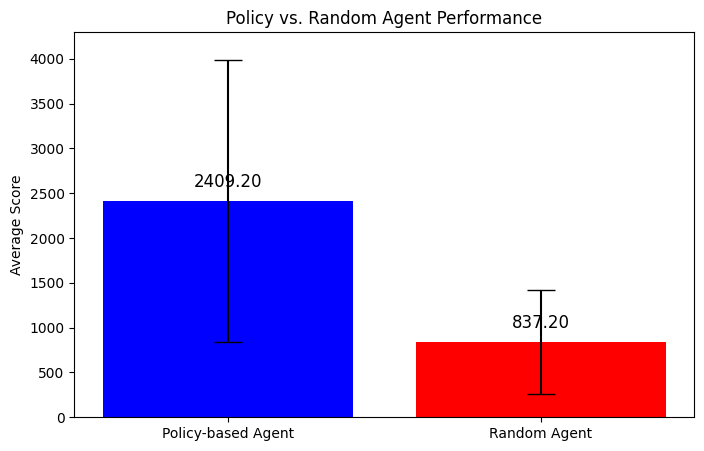

In [39]:
import copy
import random
import math
import numpy as np
import matplotlib.pyplot as plt


def evaluate_policy(env, policy_approximator, num_games=10):
    scores = []
    env.render()
    for _ in range(num_games):
        state = env.reset()
        done = False
        while not done:
            # TODO: play with your policy approximator
            action_dist = policy_approximator.predict(state)
            root = TD_MCTS_Node(state, env.score)

            # Run multiple simulations to build the MCTS search tree
            for _ in range(td_mcts.iterations):
                td_mcts.run_simulation(root)

            target_action, target_distribution = td_mcts.best_action_distribution(root)

            legal_moves = [a for a in range(4) if env.is_move_legal(a)]

            best_action = max(legal_moves, key=lambda a: action_dist[a])
            # print(action_dist, target_distribution, best_action, target_action)

            state, reward, done, _ = env.step(best_action)
            env.render(action=best_action)
        scores.append(env.score)

    return np.mean(scores), np.std(scores)


def evaluate_random(env, num_games=10):
    scores = []
    env.render()
    for _ in range(num_games):
        state = env.reset()
        done = False
        while not done:
            legal_moves = [a for a in range(4) if env.is_move_legal(a)]
            if not legal_moves:
                break
            action = random.choice(legal_moves)
            state, reward, done, _ = env.step(action)
            env.render(action=action)
        scores.append(env.score)
    return np.mean(scores), np.std(scores)


num_games = 10
policy_mean, policy_std = evaluate_policy(env, policy_approximator, num_games)
random_mean, random_std = evaluate_random(env, num_games)


print(f"Policy-based Agent - Avg Score: {policy_mean:.2f}, Std Dev: {policy_std:.2f}")
print(f"Random Agent - Avg Score: {random_mean:.2f}, Std Dev: {random_std:.2f}")

# Visualization: Compare Policy vs. Random Agent
labels = ["Policy-based Agent", "Random Agent"]
means = [policy_mean, random_mean]
std_devs = [policy_std, random_std]

plt.figure(figsize=(8, 5))
plt.bar(labels, means, yerr=std_devs, capsize=10, color=["blue", "red"])
plt.ylabel("Average Score")
plt.title("Policy vs. Random Agent Performance")
plt.ylim(0, max(means) + max(std_devs) * 1.2)


for i, v in enumerate(means):
    plt.text(i, v + max(std_devs) * 0.1, f"{v:.2f}", ha="center", fontsize=12)

plt.show()

**Question:**

- Provide a graph comparing your policy agent and random agent performance.

- What is your tuple design?

- After implementing the value and policy approximators, what is the main difference between these two?
  For example, what aspects of training require more attention for the policy approximator compared to the value approximator?

**Answer:**

- graph see above

- (Same as the previous question) Four 6-tuple from paper.

```
[
	[1, 1, 1, 1],
	[1, 1, 0, 0],
	[0, 0, 0, 0],
	[0, 0, 0, 0]
],
[
	[0, 0, 0, 0],
	[1, 1, 1, 1],
	[1, 1, 0, 0],
	[0, 0, 0, 0]
],

[
	[1, 1, 1, 0],
	[1, 1, 1, 0],
	[0, 0, 0, 0],
	[0, 0, 0, 0]
],
[
	[0, 0, 0, 0],
	[1, 1, 1, 0],
	[1, 1, 1, 0],
	[0, 0, 0, 0]
]
```

- The main difference is that the policy approximator records the values for making decision at each state while the value approximator relies on the simulated next state. To maintain the additional information of policy approximator, one has to record the transformation of the flipped symmetries so that one can distinguish their action directions to use.


## **PUCT-MCTS: Combining MCTS with Policy and Value Approximators**

### **What We Are Doing**

- We **integrate a trained policy approximator into MCTS** using the **PUCT formula**.
- This **improves exploration efficiency** by guiding MCTS with **learned action priors**.
- Instead of selecting moves **only by visit counts**, MCTS now considers **both value (Q) and policy priors (P)**.

### **Key Modifications**

1. **Selection uses the PUCT formula:**
   $Q(s, a) + c_{puct} \cdot P(s, a) \cdot \frac{\sqrt{N(s)}}{1 + N(s, a)}$

   - $Q(s, a)$: Average action value.
   - $P(s, a)$: Prior probability from the **trained policy approximator**.
   - $ N(s) $, $N(s, a)$ : Visit counts.
   - $c_{puct}$ : Controls exploration.

2. **Expansion phase now sets priors using the policy approximator.**
3. **Rollout phase still uses the value approximator but is now optional.**
4. **MCTS learns from past searches, improving decision-making over time.**

### **Why This Works**

- **Pure MCTS** spends too much time **exploring all moves equally**.
- **PUCT guides search** using **pre-learned probabilities**, reducing unnecessary exploration.
- This approach is **used in AlphaZero**, enabling **faster and stronger AI decision-making**.

🚀 **This method makes MCTS much more efficient and effective!**


In [42]:
import copy
import math
import random
import numpy as np


class PUCTNode:
    def __init__(self, state, score, parent=None, action=None, prior=0.0):
        self.state = state
        self.score = score
        self.parent = parent
        self.action = action
        self.prior = prior
        self.children = {}
        self.visits = 0
        self.total_reward = 0.0
        self.untried_actions = [a for a in range(4) if env.is_move_legal(a)]

    def fully_expanded(self):
        return len(self.untried_actions) == 0


class MCTS_PUCT:
    def __init__(
        self,
        env,
        value_approximator,
        policy_approximator,
        iterations=500,
        c_puct=1.41,
        rollout_depth=10,
        gamma=0.99,
    ):
        self.env = env
        self.value_approximator = value_approximator
        self.policy_approximator = policy_approximator
        self.iterations = iterations
        self.c_puct = c_puct
        self.rollout_depth = rollout_depth
        self.gamma = gamma

    def create_env_from_state(self, state, score):
        """Creates a deep copy of the environment to simulate a given state."""
        # new_env = Game2048Env()
        # new_env.reset(state, score)
        # return new_env
        new_env = copy.deepcopy(self.env)
        new_env.board = state.copy()
        new_env.score = score
        return new_env

    def select_child(self, node):
        # TODO: Select the best child using the PUCT formula:
        # PUCT(s,a) = Q(s,a) + c_puct * P(s,a) * sqrt(N(s)) / (1 + N(s,a))
        # where Q(s,a) = child.total_reward / child.visits.

        if len(node.untried_actions) != 0:
            return node.children[node.untried_actions[0]]
        else:
            puct_max = -np.inf
            child_max = None
            for action, child in node.children.items():
                puct_value = child.total_reward / child.visits + self.c_puct * np.sqrt(
                    np.log(node.visits) / (1 + child.visits)
                )
                if puct_value > puct_max:
                    puct_max = puct_value
                    child_max = child

            return child_max

    def rollout(self, sim_env, depth):
        # TODO: Perform a random rollout until reaching the maximum depth or a terminal state.
        # TODO: Use the approximator to evaluate the final state.
        state = sim_env.board.copy()
        while not sim_env.is_game_over() and depth > 0:
            legal_moves = [a for a in range(4) if sim_env.is_move_legal(a)]
            if len(legal_moves) == 0:
                break
            action = random.choice(legal_moves)
            state, _, done, _ = sim_env.step(action)
            depth -= 1

        return sim_env.score + self.value_approximator.value(state)

        # Note: It's not necessary to perform rollouts if the value approximator is accurate.
        value_est = self.value_approximator.value(sim_env.board)
        return value_est

    def backpropagate(self, node, reward):
        # TODO: Propagate the reward up the tree, updating visit counts and total rewards.
        while node is not None:
            node.visits += 1
            node.total_reward += reward
            node = node.parent

    def run_simulation(self, root):
        node = root

        # TODO: Selection phase: traverse the tree until reaching an expandable node.
        while node.fully_expanded():
            child = self.select_child(node)
            if child is None:
                break
            node = child

        sim_env = self.create_env_from_state(node.state, node.score)
        # TODO: Expansion phase: if the node is not terminal, expand one untried action.
        if len(node.untried_actions) != 0:
            action = random.choice(node.untried_actions)
            node.untried_actions.remove(action)
            state, score, done, _ = sim_env.step(action)
            expanded_node = PUCTNode(state, score)
            node.children[action] = expanded_node
            expanded_node.parent = node
            node = expanded_node

        # Rollout phase: simulate random moves from the expanded node.
        rollout_reward = self.rollout(sim_env, self.rollout_depth)
        # Backpropagation phase: update the tree with the obtained reward.
        self.backpropagate(node, rollout_reward)

    def best_action_distribution(self, root):
        total_visits = sum(child.visits for child in root.children.values())
        distribution = np.zeros(4)
        best_visits = -1
        best_action = None
        for action, child in root.children.items():
            distribution[action] = (
                child.visits / total_visits if total_visits > 0 else 0
            )
            if child.visits > best_visits:
                best_visits = child.visits
                best_action = action
        return best_action, distribution

**Question:**  
Implementation details of your **PUCT-MCTS**.  
Since there are many differences between **PUCT-MCTS** and **UCT-MCTS** (policy, value), please provide a detailed explanation of your implementation.  
For example, describe the differences in **selection, expansion, or other relevant aspects**.

- **_Note: Ensure that your explanation matches the actual implementation, or points will be deducted._**

**Answer:**


### **Playing 2048 Using PUCT-MCTS with TD-Learned Approximators**

- We play **2048 using PUCT-MCTS**, which combines **Monte Carlo Tree Search** with:
- **A value approximator** trained via **TD-learning** (N-Tuple function).
- **A policy approximator** trained via **self-play with MCTS**.


In [45]:
env = Game2048Env()

# Reset the environment and render the initial state
state = env.reset()
env.render()

mcts_puct = MCTS_PUCT(
    env,
    value_approximator=approximator,
    policy_approximator=policy_approximator,
    iterations=50,
    c_puct=1.41,
    rollout_depth=10,
    gamma=0.99,
)

done = False
while not done:
    root = PUCTNode(state, env.score)
    for _ in range(mcts_puct.iterations):
        mcts_puct.run_simulation(root)

    best_act, visit_distribution = mcts_puct.best_action_distribution(root)
    print(
        "PUCT selected action:",
        best_act,
        "with visit distribution:",
        visit_distribution,
    )

    state, reward, done, _ = env.step(best_act)
    env.render(action=best_act)

print("Game over, final score:", env.score)

PUCT selected action: 0 with visit distribution: [0.68 0.02 0.02 0.28]
PUCT selected action: 2 with visit distribution: [0.46 0.02 0.5  0.02]
PUCT selected action: 2 with visit distribution: [0.   0.04 0.92 0.04]
PUCT selected action: 2 with visit distribution: [0.02 0.14 0.8  0.04]
PUCT selected action: 0 with visit distribution: [0.82 0.16 0.   0.02]
PUCT selected action: 2 with visit distribution: [0.   0.16 0.82 0.02]
PUCT selected action: 3 with visit distribution: [0.04 0.1  0.1  0.76]
PUCT selected action: 0 with visit distribution: [0.86 0.1  0.02 0.02]
PUCT selected action: 0 with visit distribution: [0.9  0.04 0.04 0.02]
PUCT selected action: 1 with visit distribution: [0.04 0.36 0.26 0.34]
PUCT selected action: 2 with visit distribution: [0.04 0.02 0.92 0.02]
PUCT selected action: 1 with visit distribution: [0.02 0.92 0.02 0.04]
PUCT selected action: 2 with visit distribution: [0.34 0.04 0.56 0.06]
PUCT selected action: 2 with visit distribution: [0.02 0.02 0.94 0.02]
PUCT s

## **Self-Play Training for PUCT-MCTS (Like AlphaZero, But Without Neural Networks!)**

### **What We Are Doing**

- We are implementing a **self-play reinforcement learning framework** similar to **AlphaZero**.
- Instead of using **deep neural networks**, we use:
  - **A policy approximator (table-based)**
  - **A value approximator (N-Tuple function)**
  - **Monte Carlo Tree Search with PUCT (MCTS-PUCT)**
- This allows **efficient training** without requiring **GPU-heavy deep learning models**.

### **Why This Is Like AlphaZero**

1. **Self-play** is used to **train both policy & value approximators**.
2. **MCTS guides exploration**, and the **policy learns from MCTS visit counts**.
3. **The value function is updated** based on MCTS rollouts.
4. **No pre-training is required**—the agent **improves purely through self-play**.  
   **(Note: Although pre-training is not required, we use a pre-trained value table to accelerate learning.)**

### **Why This Works Without Neural Networks**

- **N-Tuple approximators** efficiently estimate state values.
- **Policy tables** generalize well in smaller action spaces (like 2048).
- **PUCT-MCTS improves search efficiency**, making deep networks unnecessary.

🚀 **This is a lightweight, efficient version of AlphaZero, optimized for 2048!**


In [50]:
def self_play_training_policy_value(
    env,
    mcts_puct,
    policy_approximator,
    value_approximator,
    num_episodes=50,
    value_lr=0.01,
):
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        previous_score = 0

        while not done:
            # Create the root node for the MCTS-PUCT tree
            root = PUCTNode(state, env.score)

            # Run multiple simulations to build the MCTS search tree
            for _ in range(mcts_puct.iterations):
                mcts_puct.run_simulation(root)

            best_action, target_distribution = td_mcts.best_action_distribution(root)
            # TODO: Update the NTuple Policy Approximator using the MCTS action distribution
            policy_approximator.update(state, target_distribution)
            # TODO: Calculate the TD error for the value approximator and update your approximator

            # Execute the selected action in the real environment
            next_state, new_score, done, _ = env.step(best_action)

            incremental_reward = new_score - previous_score

            # gamma = 0.99
            delta = (
                incremental_reward
                + approximator.value(next_state)
                - approximator.value(state)
            )
            value_approximator.update(state, delta, value_lr)

            previous_score = new_score
            state = next_state
            # print(state)

        print(
            f"Episode {episode + 1}/{num_episodes} finished, final score: {env.score}"
        )

In [51]:
# Instantiate the PUCT MCTS object using the pre-trained NTuple-based approximators.

mcts_puct = MCTS_PUCT(
    env,
    value_approximator=approximator,
    policy_approximator=policy_approximator,
    iterations=50,
    c_puct=1.41,
    rollout_depth=10,
    gamma=0.99,
)

# Run the self-play training loop to further update both the policy and value approximators.
self_play_training_policy_value(
    env, mcts_puct, policy_approximator, approximator, num_episodes=10, value_lr=0.01
)

Episode 1/10 finished, final score: 5256
Episode 2/10 finished, final score: 5256
Episode 3/10 finished, final score: 6408
Episode 4/10 finished, final score: 7144
Episode 5/10 finished, final score: 4684
Episode 6/10 finished, final score: 3128
Episode 7/10 finished, final score: 15872
Episode 8/10 finished, final score: 7152
Episode 9/10 finished, final score: 5376
Episode 10/10 finished, final score: 5416


**Question:**

- Provide a **graph showing training steps vs. score progression** to illustrate learning performance.

**Answer:**


### **Playing 2048 Using PUCT-MCTS with Trained Approximators**

- Now that we have **trained the policy and value approximators** through self-play, we **test them in actual gameplay**.
- The agent will play **2048 using PUCT-MCTS**, making **smarter, more efficient decisions**.
- This is the **final step**, where we evaluate how well our training has improved the agent.

🚀 **Now, let's see how well our trained agent plays 2048!**


In [52]:
state = env.reset()
env.render()

mcts_puct = MCTS_PUCT(
    env,
    value_approximator=approximator,
    policy_approximator=policy_approximator,
    iterations=50,
    c_puct=1.41,
    rollout_depth=10,
    gamma=0.99,
)

done = False
while not done:
    root = PUCTNode(state, env.score)
    for _ in range(mcts_puct.iterations):
        mcts_puct.run_simulation(root)

    best_act, visit_distribution = mcts_puct.best_action_distribution(root)
    print(
        "PUCT selected action:",
        best_act,
        "with visit distribution:",
        visit_distribution,
    )

    state, reward, done, _ = env.step(best_act)
    env.render(action=best_act)


# Print final results
max_tile = np.max(state)  # Get the highest tile achieved
print(f"Game over! Final score: {env.score}, Highest tile: {max_tile}")

PUCT selected action: 2 with visit distribution: [0.04 0.02 0.92 0.02]
PUCT selected action: 2 with visit distribution: [0.16 0.08 0.74 0.02]
PUCT selected action: 1 with visit distribution: [0.02 0.8  0.02 0.16]
PUCT selected action: 0 with visit distribution: [0.68 0.22 0.08 0.02]
PUCT selected action: 2 with visit distribution: [0.04 0.02 0.9  0.04]
PUCT selected action: 3 with visit distribution: [0.02 0.02 0.   0.96]
PUCT selected action: 0 with visit distribution: [0.86 0.04 0.08 0.02]
PUCT selected action: 2 with visit distribution: [0.   0.06 0.64 0.3 ]
PUCT selected action: 0 with visit distribution: [0.54 0.42 0.02 0.02]
PUCT selected action: 1 with visit distribution: [0.02 0.92 0.   0.06]
PUCT selected action: 1 with visit distribution: [0.08 0.62 0.02 0.28]
PUCT selected action: 1 with visit distribution: [0.04 0.92 0.02 0.02]
PUCT selected action: 2 with visit distribution: [0.04 0.14 0.8  0.02]
PUCT selected action: 1 with visit distribution: [0.02 0.86 0.06 0.06]
PUCT s

💡 Tip: Make the most of these two questions (Q1 & Q2) to understand key techniques—they can be directly applied to Q3 to maximize your score! Keep pushing forward, and aim for the best results! 💪🔥
